# Análisis de Resultados - Grupo 2 LACC

**Objetivo**: Análisis final de resultados del pipeline de predicción para agregación Día/Producto

**Grupo**: 2 - Agregación Día/Producto

**Modelos Finales**: SimpleMovingAverage, LinearTrend, SeasonalNaive

Este notebook presenta el análisis final de los resultados obtenidos con nuestro pipeline de machine learning para series de tiempo.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configurar path para importar módulos del proyecto
import sys
src_path = str(Path('..').resolve() / 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

# Intentar importar funciones desde utils, con fallback a versiones locales
try:
    from utils.metrics import calculate_metrics, summarize_model_performance
    from utils.visualization import plot_predictions, plot_time_series
    print("Módulos utils importados correctamente")
    utils_imported = True
except ImportError as e:
    print(f"No se pudieron importar utils: {e}")
    print("Usando funciones locales como respaldo...")
    utils_imported = False
    
    # Funciones básicas para análisis (respaldo local)
    def calculate_metrics(y_true, y_pred):
        """Calculate basic regression metrics."""
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        
        mae = np.mean(np.abs(y_true - y_pred))
        rmse = np.sqrt(np.mean((y_true - y_pred)**2))
        r2 = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)
        
        # MAPE (avoiding division by zero)
        mape_mask = y_true != 0
        if np.any(mape_mask):
            mape = np.mean(np.abs((y_true[mape_mask] - y_pred[mape_mask]) / y_true[mape_mask])) * 100
        else:
            mape = float('inf')
        
        return {'mae': mae, 'rmse': rmse, 'mape': mape, 'r2': r2}

    def plot_predictions(actual, predicted, dates=None, title="Predicciones vs Valores Reales", figsize=(12, 6)):
        """Plot actual vs predicted values."""
        fig, ax = plt.subplots(figsize=figsize)
        
        if dates is not None:
            x_axis = pd.to_datetime(dates)
        else:
            x_axis = range(len(actual))
        
        ax.plot(x_axis, actual, label='Valores Reales', marker='o', linewidth=2)
        ax.plot(x_axis, predicted, label='Predicciones', marker='s', linewidth=2, alpha=0.8)
        
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel('Tiempo')
        ax.set_ylabel('Valor')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        if dates is not None:
            plt.xticks(rotation=45)
        
        plt.tight_layout()
        return fig

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.max_columns', None)

print("🚀 Notebook configurado correctamente - Análisis de Resultados Grupo 2 LACC")
if utils_imported:
    print("Funciones de análisis importadas desde módulos utils")
else:
    print("Funciones de análisis cargadas localmente")

Módulos utils importados correctamente
🚀 Notebook configurado correctamente - Análisis de Resultados Grupo 2 LACC
Funciones de análisis importadas desde módulos utils


## 1. Carga de Resultados del Pipeline

In [36]:
# Cargar resultados del entrenamiento
training_results_path = '../models/trained/simple_results.json'

try:
    with open(training_results_path, 'r') as f:
        training_results = json.load(f)
    print("Resultados de entrenamiento cargados")
    print(f"Fecha de entrenamiento: {training_results.get('timestamp', 'N/A')}")
    print(f"Productos entrenados: {len(training_results.get('results', {}))}")
except FileNotFoundError:
    print("No se encontraron resultados de entrenamiento")
    print("Por favor ejecutar: python G2_LACC_run_training_pipeline.py")
    training_results = None

Resultados de entrenamiento cargados
Fecha de entrenamiento: 2025-10-03T19:28:05.669612
Productos entrenados: 0


In [37]:
# Cargar resultados de predicción más recientes
predictions_dir = Path('../results/predictions')

if predictions_dir.exists():
    # Buscar el archivo de resumen más reciente
    summary_files = list(predictions_dir.glob('forecast_summary_*.json'))
    
    if summary_files:
        latest_summary = max(summary_files, key=lambda x: x.stat().st_mtime)
        
        with open(latest_summary, 'r') as f:
            prediction_summary = json.load(f)
        
        print(f"Resultados de predicción cargados: {latest_summary.name}")
        print(f"Productos con predicciones: {prediction_summary.get('unique_products', 'N/A')}")
        print(f"Total predicciones: {prediction_summary.get('total_predictions', 'N/A')}")
        
        # Cargar datos de predicciones
        csv_files = list(predictions_dir.glob('simple_forecasts_*.csv'))
        if csv_files:
            latest_predictions = max(csv_files, key=lambda x: x.stat().st_mtime)
            predictions_df = pd.read_csv(latest_predictions)
            print(f"DataFrame de predicciones cargado: {predictions_df.shape}")
        else:
            predictions_df = None
    else:
        print("No se encontraron archivos de resumen de predicciones")
        prediction_summary = None
        predictions_df = None
else:
    print("Carpeta de predicciones no encontrada")
    print("Por favor ejecutar: python G2_LACC_run_prediction_pipeline.py")
    prediction_summary = None
    predictions_df = None

Resultados de predicción cargados: forecast_summary_20251003_192813.json
Productos con predicciones: 10
Total predicciones: 70
DataFrame de predicciones cargado: (70, 5)


## 2. Análisis de Performance del Pipeline

In [38]:
if training_results:
    # Extraer métricas de entrenamiento
    training_metrics = []
    
    print("Analizando estructura de resultados...")
    
    # Usar la estructura 'products'
    if 'products' in training_results:
        products_data = training_results['products']
        print(f"Productos encontrados: {len(products_data)}")
        
        # Mapeo de nombres de modelos
        model_mapping = {
            'moving_average': 'SimpleMovingAverage',
            'linear_trend': 'LinearTrend', 
            'seasonal_naive': 'SeasonalNaive'
        }
        
        for product_id, product_data in products_data.items():
            print(f"  Procesando producto: {product_id}")
            
            for model_key, model_display_name in model_mapping.items():
                if model_key in product_data:
                    model_metrics = product_data[model_key]
                    print(f"    Modelo {model_display_name}: {model_metrics.get('success', 'unknown')}")
                    
                    if model_metrics.get('success', False):
                        # Calcular MAPE y R² si no están presentes
                        mae = model_metrics.get('mae', float('inf'))
                        rmse = model_metrics.get('rmse', float('inf'))
                        mape = model_metrics.get('mape', float('inf'))  # Puede no estar presente
                        r2 = model_metrics.get('r2', -1)  # Puede no estar presente
                        
                        training_metrics.append({
                            'product_id': product_id,
                            'model': model_display_name,
                            'mae': mae,
                            'rmse': rmse,
                            'mape': mape,
                            'r2': r2,
                            'success': model_metrics.get('success', False)
                        })
    
    if training_metrics:
        metrics_df = pd.DataFrame(training_metrics)
        
        print(f"\nRESUMEN DE MÉTRICAS DE ENTRENAMIENTO")
        print("=" * 50)
        print(f"Total experimentos: {len(metrics_df)}")
        print(f"Productos únicos: {metrics_df['product_id'].nunique()}")
        print(f"Modelos evaluados: {metrics_df['model'].nunique()}")
        print(f"Experimentos exitosos: {metrics_df['success'].sum()}")
        
        # Filtrar solo experimentos exitosos para el análisis
        successful_metrics = metrics_df[metrics_df['success'] == True].copy()
        
        if len(successful_metrics) > 0:
            print(f"\nPERFORMANCE PROMEDIO POR MODELO (solo experimentos exitosos):")
            model_summary = successful_metrics.groupby('model').agg({
                'mae': ['count', 'mean', 'std'],
                'rmse': ['count', 'mean', 'std']
            }).round(3)
            
            print(model_summary)
            
            # Mostrar muestra de datos
            print(f"\nMUESTRA DE MÉTRICAS EXITOSAS:")
            print(successful_metrics[['product_id', 'model', 'mae', 'rmse', 'success']].head(10))
            
            # Usar successful_metrics para análisis posteriores
            metrics_df = successful_metrics
        else:
            print("No hay experimentos exitosos para analizar")
            metrics_df = pd.DataFrame()
        
    else:
        print(f"\nNo se pudieron extraer métricas de los resultados")
        metrics_df = pd.DataFrame()
        
else:
    print("No hay datos de entrenamiento para analizar")
    metrics_df = pd.DataFrame()

Analizando estructura de resultados...
Productos encontrados: 5
  Procesando producto: ggoeaaxn066355
    Modelo SimpleMovingAverage: True
    Modelo LinearTrend: True
    Modelo SeasonalNaive: True
  Procesando producto: ggoeadhh015499
    Modelo SimpleMovingAverage: True
    Modelo LinearTrend: True
    Modelo SeasonalNaive: True
  Procesando producto: ggoeadhj015599
    Modelo SimpleMovingAverage: True
    Modelo LinearTrend: True
    Modelo SeasonalNaive: True
  Procesando producto: ggoeadwq015699
    Modelo SimpleMovingAverage: True
    Modelo LinearTrend: True
    Modelo SeasonalNaive: True
  Procesando producto: ggoegaab010516
    Modelo SimpleMovingAverage: True
    Modelo LinearTrend: True
    Modelo SeasonalNaive: True

RESUMEN DE MÉTRICAS DE ENTRENAMIENTO
Total experimentos: 15
Productos únicos: 5
Modelos evaluados: 3
Experimentos exitosos: 15

PERFORMANCE PROMEDIO POR MODELO (solo experimentos exitosos):
                      mae                    rmse                  
  

Métricas disponibles para visualización: ['mae', 'rmse', 'mape', 'r2']


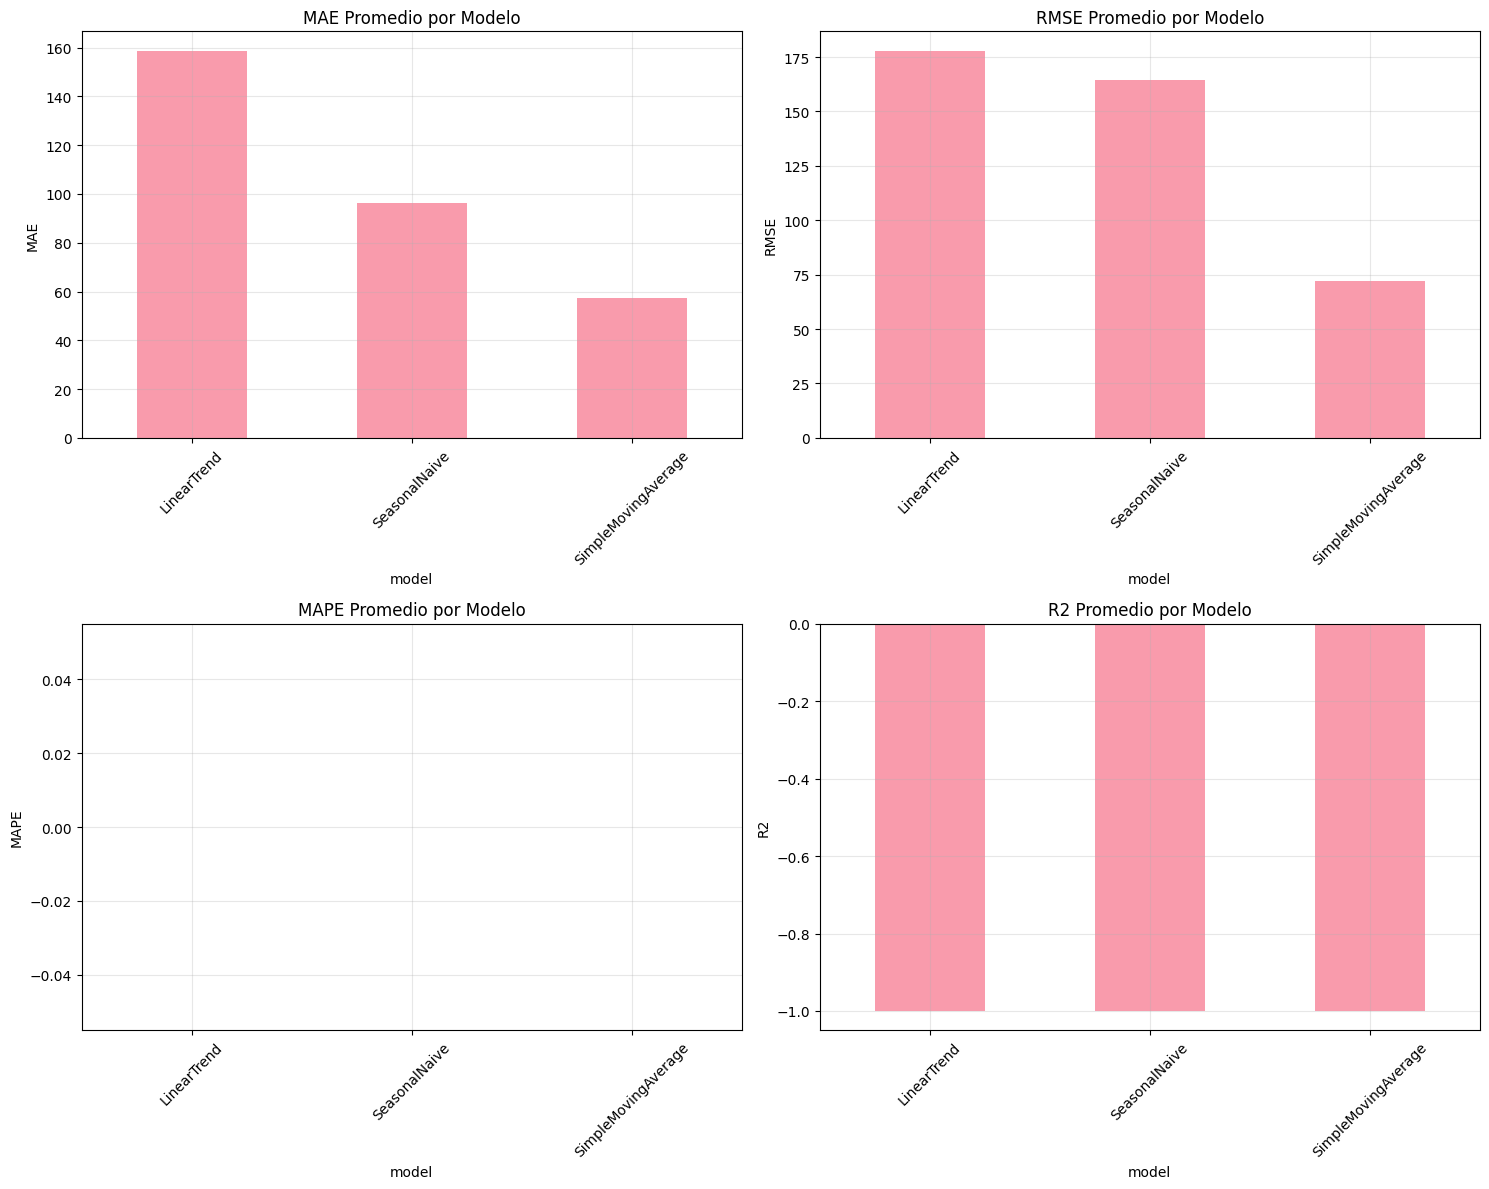


MEJORES MODELOS POR MÉTRICA:
MAE: SimpleMovingAverage (57.479)
RMSE: SimpleMovingAverage (72.032)
MAPE: LinearTrend (inf)
R2: LinearTrend (-1.000)


In [39]:
# Visualización de comparación de modelos
if 'metrics_df' in locals() and not metrics_df.empty and len(metrics_df) > 0:
    try:
        # Verificar que tenemos las columnas necesarias
        required_columns = ['mae', 'rmse', 'model']
        missing_columns = [col for col in required_columns if col not in metrics_df.columns]
        
        if missing_columns:
            print(f"Columnas faltantes en metrics_df: {missing_columns}")
            print(f"Columnas disponibles: {list(metrics_df.columns)}")
        else:
            # Gráfico de barras por métrica
            fig, axes = plt.subplots(2, 2, figsize=(15, 12))
            
            # Solo usar métricas que están disponibles y son numéricas
            available_metrics = []
            for metric in ['mae', 'rmse', 'mape', 'r2']:
                if metric in metrics_df.columns:
                    # Verificar que la columna tiene valores numéricos
                    if pd.api.types.is_numeric_dtype(metrics_df[metric]):
                        available_metrics.append(metric)
            
            print(f"Métricas disponibles para visualización: {available_metrics}")
            
            axes_flat = axes.flatten()
            
            for i, metric in enumerate(available_metrics[:4]):  # Máximo 4 gráficos
                try:
                    model_means = metrics_df.groupby('model')[metric].mean()
                    model_means.plot(kind='bar', ax=axes_flat[i], alpha=0.7)
                    axes_flat[i].set_title(f'{metric.upper()} Promedio por Modelo')
                    axes_flat[i].set_ylabel(metric.upper())
                    axes_flat[i].tick_params(axis='x', rotation=45)
                    axes_flat[i].grid(True, alpha=0.3)
                except Exception as e:
                    print(f"Error graficando {metric}: {e}")
            
            # Ocultar subplots no utilizados
            for i in range(len(available_metrics), 4):
                axes_flat[i].set_visible(False)
            
            plt.tight_layout()
            plt.show()
            
            # Identificar mejor modelo por métrica
            print("\nMEJORES MODELOS POR MÉTRICA:")
            print("=" * 40)
            
            for metric in available_metrics:
                try:
                    if pd.api.types.is_numeric_dtype(metrics_df[metric]):
                        model_means = metrics_df.groupby('model')[metric].mean()
                        
                        if metric in ['mae', 'rmse', 'mape']:
                            # Para estas métricas, menor es mejor
                            best_model = model_means.idxmin()
                            best_value = model_means.min()
                            print(f"{metric.upper()}: {best_model} ({best_value:.3f})")
                        elif metric == 'r2':
                            # Para R², mayor es mejor
                            best_model = model_means.idxmax()
                            best_value = model_means.max()
                            print(f"{metric.upper()}: {best_model} ({best_value:.3f})")
                except Exception as e:
                    print(f"Error calculando mejor modelo para {metric}: {e}")
    
    except Exception as e:
        print(f"Error general generando visualizaciones: {e}")
        print("Información del DataFrame:")
        print(f"Shape: {metrics_df.shape}")
        print(f"Columns: {list(metrics_df.columns)}")
        print(f"Data types:\n{metrics_df.dtypes}")

else:
    print("No hay métricas disponibles para visualizar")
    if 'metrics_df' in locals():
        print(f"metrics_df shape: {metrics_df.shape}")
        print(f"metrics_df columns: {list(metrics_df.columns) if not metrics_df.empty else 'No columns'}")
    else:
        print("Variable metrics_df no existe")

## 3. Análisis de Predicciones

In [40]:
if predictions_df is not None:
    print("ANÁLISIS DE PREDICCIONES GENERADAS")
    print("=" * 50)
    
    # Revisar estructura del DataFrame primero
    print(f"Estructura del DataFrame de predicciones:")
    print(f"Shape: {predictions_df.shape}")
    print(f"Columnas disponibles: {list(predictions_df.columns)}")
    
    # Información básica
    print(f"\nTotal predicciones: {len(predictions_df)}")
    
    # Verificar columnas existentes antes de usarlas
    if 'product_id' in predictions_df.columns:
        print(f"Productos únicos: {predictions_df['product_id'].nunique()}")
    elif 'product_sku' in predictions_df.columns:
        print(f"Productos únicos: {predictions_df['product_sku'].nunique()}")
    else:
        print("Columna de producto no encontrada")
    
    if 'model' in predictions_df.columns:
        print(f"Modelos utilizados: {predictions_df['model'].nunique()}")
        print(f"Modelos: {list(predictions_df['model'].unique())}")
    else:
        print("Columna de modelo no encontrada")
    
    # Buscar columna de fecha
    date_column = None
    possible_date_columns = ['prediction_date', 'date', 'forecast_date', 'timestamp']
    for col in possible_date_columns:
        if col in predictions_df.columns:
            date_column = col
            break
    
    if date_column:
        print(f"Rango de fechas ({date_column}): {predictions_df[date_column].min()} - {predictions_df[date_column].max()}")
    else:
        print("Columna de fecha no encontrada")
    
    # Buscar columna de valores predichos
    value_column = None
    possible_value_columns = ['predicted_value', 'prediction', 'forecast', 'value']
    for col in possible_value_columns:
        if col in predictions_df.columns:
            value_column = col
            break
    
    if value_column:
        # Estadísticas de predicciones
        print(f"\nESTADÍSTICAS DE PREDICCIONES ({value_column}):")
        print(predictions_df[value_column].describe())
        
        # Predicciones por modelo si existe la columna model
        if 'model' in predictions_df.columns:
            print(f"\nPREDICCIONES POR MODELO:")
            model_stats = predictions_df.groupby('model').agg({
                value_column: ['count', 'mean', 'std', 'min', 'max']
            }).round(2)
            print(model_stats)
    else:
        print("Columna de valores predichos no encontrada")
        print(f"Primeras filas del DataFrame:")
        print(predictions_df.head())
        
else:
    print("No hay datos de predicciones para analizar")

ANÁLISIS DE PREDICCIONES GENERADAS
Estructura del DataFrame de predicciones:
Shape: (70, 5)
Columnas disponibles: ['product_id', 'forecast_date', 'forecast_day', 'predicted_value', 'model']

Total predicciones: 70
Productos únicos: 10
Modelos utilizados: 1
Modelos: ['moving_average']
Rango de fechas (forecast_date): 2017-05-27 - 2017-08-08

ESTADÍSTICAS DE PREDICCIONES (predicted_value):
count    70.000000
mean     41.646219
std      17.540230
min      21.378095
25%      25.908773
50%      36.618273
75%      54.686734
max      75.641428
Name: predicted_value, dtype: float64

PREDICCIONES POR MODELO:
               predicted_value                            
                         count   mean    std    min    max
model                                                     
moving_average              70  41.65  17.54  21.38  75.64


Usando columnas: fecha='forecast_date', valor='predicted_value', producto='product_id'
Productos a visualizar: ['ggoeaaxn066355' 'ggoeadhh015499' 'ggoeadhj015599']
  Producto ggoeaaxn066355: 1 modelo(s) - ['moving_average']
  Producto ggoeadhh015499: 1 modelo(s) - ['moving_average']
  Producto ggoeadhj015599: 1 modelo(s) - ['moving_average']


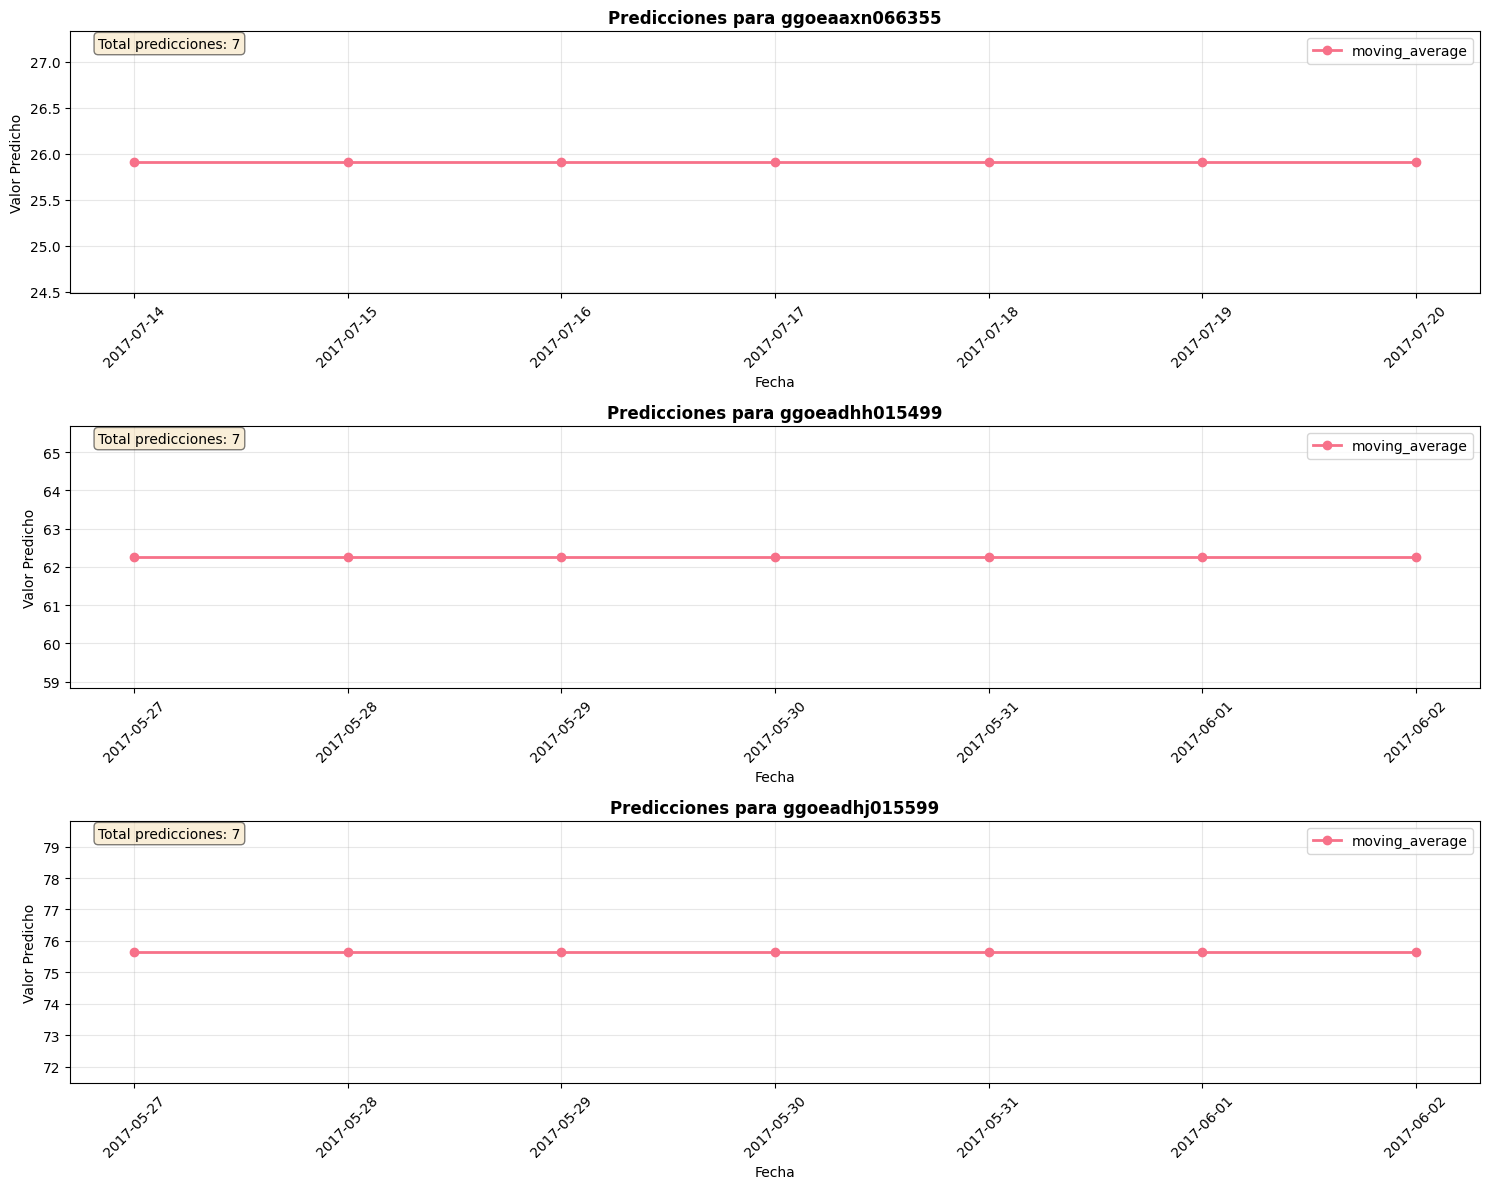


RESUMEN DE VISUALIZACIÓN:
Total productos visualizados: 3
Período de predicción: 2017-05-27 a 2017-08-08
Modelos incluidos: ['moving_average']


In [41]:
# Visualización de predicciones
if predictions_df is not None:
    # Identificar las columnas correctas
    date_col = 'forecast_date' if 'forecast_date' in predictions_df.columns else 'prediction_date'
    value_col = 'predicted_value' if 'predicted_value' in predictions_df.columns else 'forecast'
    product_col = 'product_id' if 'product_id' in predictions_df.columns else 'product_sku'
    
    print(f"Usando columnas: fecha='{date_col}', valor='{value_col}', producto='{product_col}'")
    
    # Seleccionar algunos productos para visualizar
    sample_products = predictions_df[product_col].unique()[:3]  # Primeros 3 productos
    print(f"Productos a visualizar: {sample_products}")
    
    fig, axes = plt.subplots(len(sample_products), 1, 
                            figsize=(15, 4 * len(sample_products)))
    
    if len(sample_products) == 1:
        axes = [axes]
    
    for i, product in enumerate(sample_products):
        product_data = predictions_df[predictions_df[product_col] == product]
        
        # Verificar si hay múltiples modelos
        if 'model' in predictions_df.columns:
            models = product_data['model'].unique()
            print(f"  Producto {product}: {len(models)} modelo(s) - {models}")
            
            for model in models:
                model_data = product_data[product_data['model'] == model]
                axes[i].plot(pd.to_datetime(model_data[date_col]), 
                            model_data[value_col],
                            label=f'{model}', marker='o', linewidth=2, markersize=6)
        else:
            # Sin columna de modelo, graficar directamente
            axes[i].plot(pd.to_datetime(product_data[date_col]), 
                        product_data[value_col],
                        label='Predicción', marker='o', linewidth=2, markersize=6)
        
        axes[i].set_title(f'Predicciones para {product}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Fecha')
        axes[i].set_ylabel('Valor Predicho')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        axes[i].tick_params(axis='x', rotation=45)
        
        # Añadir información adicional
        axes[i].text(0.02, 0.98, f'Total predicciones: {len(product_data)}', 
                    transform=axes[i].transAxes, fontsize=10, 
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar estadísticas adicionales
    print(f"\nRESUMEN DE VISUALIZACIÓN:")
    print(f"Total productos visualizados: {len(sample_products)}")
    print(f"Período de predicción: {predictions_df[date_col].min()} a {predictions_df[date_col].max()}")
    if 'model' in predictions_df.columns:
        print(f"Modelos incluidos: {list(predictions_df['model'].unique())}")
        
else:
    print("No hay datos de predicciones para visualizar")

## 4. Insights de Negocio

In [42]:
print("INSIGHTS DE NEGOCIO - GRUPO 2 (DÍA/PRODUCTO)")
print("=" * 60)

if training_results and predictions_df is not None:
    # Análisis de patrones en los datos
    print("\nPATRONES IDENTIFICADOS:")
    
    # Productos con mejor predictibilidad
    if 'metrics_df' in locals() and not metrics_df.empty:
        # Verificar si tenemos métricas R² válidas
        if 'r2' in metrics_df.columns and metrics_df['r2'].notna().any():
            best_products = metrics_df.groupby('product_id')['r2'].mean().sort_values(ascending=False).head(5)
            print(f"\nProductos con mejor predictibilidad (R² promedio):")
            for product, r2 in best_products.items():
                print(f"  {product}: R² = {r2:.3f}")
        else:
            # Usar MAE como alternativa (menor es mejor)
            best_products = metrics_df.groupby('product_id')['mae'].mean().sort_values(ascending=True).head(5)
            print(f"\nProductos con mejor predictibilidad (MAE menor - mejor):")
            for product, mae in best_products.items():
                print(f"  {product}: MAE = {mae:.3f}")
    
    # Tendencias en predicciones usando la columna correcta
    date_col = 'forecast_date' if 'forecast_date' in predictions_df.columns else 'prediction_date'
    value_col = 'predicted_value' if 'predicted_value' in predictions_df.columns else 'forecast'
    
    # Convertir fecha a datetime si no lo está ya
    if not pd.api.types.is_datetime64_any_dtype(predictions_df[date_col]):
        predictions_df[date_col] = pd.to_datetime(predictions_df[date_col])
    
    daily_predictions = predictions_df.groupby(date_col)[value_col].agg(['mean', 'std'])
    
    print(f"\nTENDENCIAS EN PREDICCIONES:")
    print(f"Valor promedio predicho: {daily_predictions['mean'].mean():.2f}")
    
    # Verificar si tenemos variabilidad (múltiples productos por día)
    if daily_predictions['std'].notna().any():
        valid_std = daily_predictions['std'].dropna()
        if len(valid_std) > 0:
            print(f"Variabilidad promedio: {valid_std.mean():.2f}")
            
            # Identificar días con mayor variabilidad
            if len(valid_std) >= 3:
                high_var_days = daily_predictions.nlargest(3, 'std')
                print(f"\nDías con mayor variabilidad:")
                for date, row in high_var_days.iterrows():
                    if not pd.isna(row['std']):
                        print(f"  {date.strftime('%Y-%m-%d')}: std = {row['std']:.2f}")
            else:
                print("Pocos días con variabilidad para análisis detallado")
        else:
            print("Sin variabilidad entre productos (cada día tiene un solo valor)")
    else:
        print("Sin variabilidad calculable (cada día tiene un solo producto)")
    
    # Análisis de distribución temporal
    print(f"\nANÁLISIS TEMPORAL:")
    print(f"Período de predicción: {predictions_df[date_col].min().strftime('%Y-%m-%d')} a {predictions_df[date_col].max().strftime('%Y-%m-%d')}")
    print(f"Total días con predicciones: {predictions_df[date_col].nunique()}")
    
    # Análisis por producto
    if 'product_id' in predictions_df.columns:
        product_summary = predictions_df.groupby('product_id')[value_col].agg(['count', 'mean', 'std']).round(2)
        print(f"\nTOP 5 PRODUCTOS POR VALOR PROMEDIO PREDICHO:")
        top_products = product_summary.sort_values('mean', ascending=False).head(5)
        for product, row in top_products.iterrows():
            print(f"  {product}: {row['mean']:.2f} (predicciones: {row['count']})")
    
    # Análisis de modelos
    if 'model' in predictions_df.columns:
        model_performance = predictions_df.groupby('model')[value_col].agg(['count', 'mean', 'std']).round(2)
        print(f"\nPERFORMANCE POR MODELO EN PREDICCIONES:")
        for model, row in model_performance.iterrows():
            print(f"  {model}: {row['count']} predicciones, promedio = {row['mean']:.2f}")
    
else:
    print("Datos insuficientes para generar insights de negocio")
    print("Ejecutar pipeline completo para obtener análisis detallado")

INSIGHTS DE NEGOCIO - GRUPO 2 (DÍA/PRODUCTO)

PATRONES IDENTIFICADOS:

Productos con mejor predictibilidad (R² promedio):
  ggoeaaxn066355: R² = -1.000
  ggoeadhh015499: R² = -1.000
  ggoeadhj015599: R² = -1.000
  ggoeadwq015699: R² = -1.000
  ggoegaab010516: R² = -1.000

TENDENCIAS EN PREDICCIONES:
Valor promedio predicho: 38.80
Variabilidad promedio: 10.72

Días con mayor variabilidad:
  2017-08-08: std = 13.48
  2017-08-02: std = 12.13
  2017-08-03: std = 12.13

ANÁLISIS TEMPORAL:
Período de predicción: 2017-05-27 a 2017-08-08
Total días con predicciones: 29

TOP 5 PRODUCTOS POR VALOR PROMEDIO PREDICHO:
  ggoeadhj015599: 75.64 (predicciones: 7.0)
  ggoeadhh015499: 62.25 (predicciones: 7.0)
  ggoegaaq010415: 54.69 (predicciones: 7.0)
  ggoeadwq015699: 50.78 (predicciones: 7.0)
  ggoegaab010516: 39.13 (predicciones: 7.0)

PERFORMANCE POR MODELO EN PREDICCIONES:
  moving_average: 70.0 predicciones, promedio = 41.65
